In [0]:
# Clasificador de BF con Chalearn en BN y Keras
# Miguelangel Moreno Sotelo

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import random
import time
import pickle
import keras
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dropout
from keras.models import Model
from keras import backend as K
from keras.models import model_from_json
from keras import optimizers
from keras import losses
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from PIL import Image,ImageOps

Using TensorFlow backend.


## DataSet

In [2]:
class DataSet:
    data_train = None;
    data_test  = None;
    
    # 30935 total
    total_train = 28152;
    total_test  =  2783;
       
    
    def read_pickle(self, name, show=False):
        
        if show:
            print('Cargando pickle',"../DataSet/{}.pickle".format(name));
        pic = pickle.load(open("../DataSet/{}.pickle".format(name), "rb"));
        
        X = np.array(pic['X']);   
        Y = np.array(pic['Y']);
        
        if show:
           print('X-',X.shape)
           print('Y-',Y.shape)        
                
        return X,Y;
                         
        
    def load_dataset(self):
        self.data_train = dict(X=[],Y=[]);
        self.data_test  = dict(X=[],Y=[]);
        
        for i in range(1,4):
            x,y = self.read_pickle('train_clselfie_v4_{}'.format(i), show=True);
            self.data_train['X'].extend(x);
            self.data_train['Y'].extend(y);
        
        x,y = self.read_pickle('test_clselfie_v4', show=True);
        self.data_test['X'].extend(x);
        self.data_test['Y'].extend(y);
           
        
        
        self.data_train['X'] = np.array(self.data_train['X']);        
        self.data_train['Y'] = np.array(self.data_train['Y']);
                
        self.data_test['X'] = np.array(self.data_test['X']);
        self.data_test['Y'] = np.array(self.data_test['Y']);     
       
        
        
        
        print('\nTotal Train Data X:',self.data_train['X'].shape,'Y:',self.data_train['Y'].shape);
        print('Total Test  Data X:',self.data_test['X'].shape,'Y:',self.data_test['Y'].shape);  
        
        
    def normalize_images(self):
        
        print('\nNormalizando')
        train_x = [];
        test_x = [];
        
        for i in range(self.data_train['X'].shape[0]):
            train_x.append(self.data_train['X'][i] / 255);
            
        for i in range(self.data_test['X'].shape[0]):
            test_x.append(self.data_test['X'][i] / 255)
            
        self.data_train['X'] = np.array(train_x);
        self.data_test['X'] = np.array(test_x);
          
        
        print('Total Train Data X:',self.data_train['X'].shape,'Y:',self.data_train['Y'].shape);
        print('Total Test  Data X:',self.data_test['X'].shape,'Y:',self.data_test['Y'].shape);    
        

        

In [3]:
# Cargamos Dataset
ds = DataSet();
ds.load_dataset();

Cargando pickle ../DataSet/train_clselfie_v4_1.pickle
X- (9000, 208, 208, 1)
Y- (9000, 5)
Cargando pickle ../DataSet/train_clselfie_v4_2.pickle
X- (9000, 208, 208, 1)
Y- (9000, 5)
Cargando pickle ../DataSet/train_clselfie_v4_3.pickle
X- (10152, 208, 208, 1)
Y- (10152, 5)
Cargando pickle ../DataSet/test_clselfie_v4.pickle
X- (2783, 208, 208, 1)
Y- (2783, 5)

Total Train Data X: (28152, 208, 208, 1) Y: (28152, 5)
Total Test  Data X: (2783, 208, 208, 1) Y: (2783, 5)


In [4]:
print(ds.data_train['X'][0][0][0])

ds.normalize_images();

print('\n',ds.data_train['X'][0][0][0])

[198]

Normalizando
Total Train Data X: (28152, 208, 208, 1) Y: (28152, 5)
Total Test  Data X: (2783, 208, 208, 1) Y: (2783, 5)

 [0.77647059]


Y [0.72222222 0.60194175 0.57943925 0.50549451 0.59375   ]


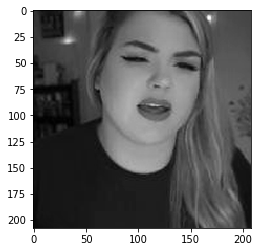

Y [0.66666667 0.51456311 0.44859813 0.65934066 0.54166667]


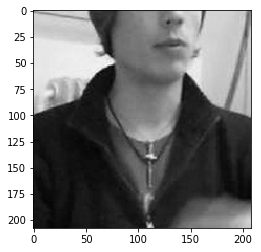

Y [0.51111111 0.3592233  0.3364486  0.41758242 0.27083333]


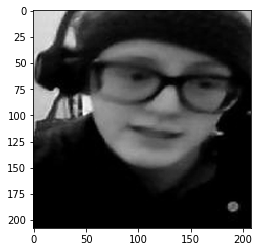

Y [0.32222222 0.18446602 0.18691589 0.17582418 0.13541667]


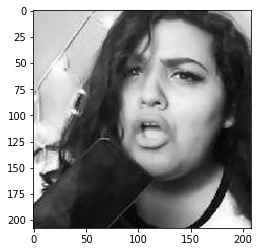

Y [0.34444444 0.37864078 0.22429907 0.37362637 0.40625   ]


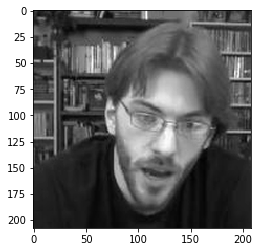

Y [0.26666667 0.33980583 0.30841121 0.42857143 0.34375   ]


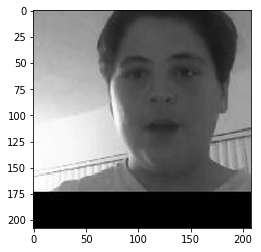

Y [0.73333333 0.69902913 0.69158879 0.73626374 0.6875    ]


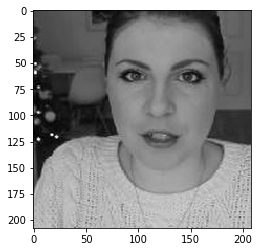

Y [0.72222222 0.69902913 0.72897196 0.71428571 0.67708333]


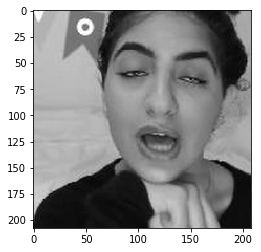

Y [0.8        0.85436893 0.68224299 0.52747253 0.72916667]


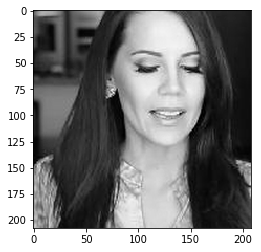

Y [0.67777778 0.6407767  0.53271028 0.61538462 0.44791667]


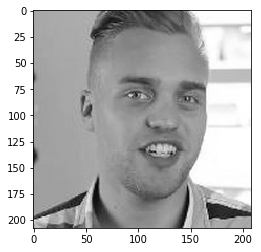

Y [0.52222222 0.5631068  0.42056075 0.45054945 0.58333333]


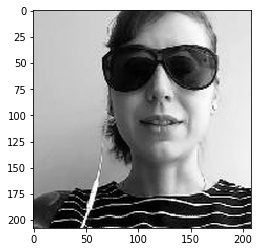

Y [0.66666667 0.39805825 0.58878505 0.42857143 0.70833333]


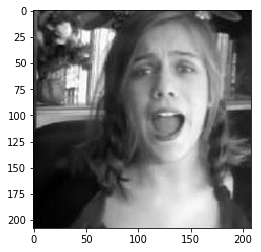

Y [0.63333333 0.60194175 0.5046729  0.74725275 0.52083333]


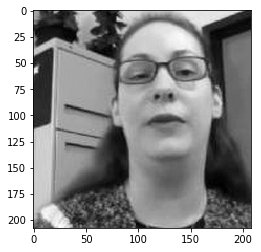

Y [0.88888889 0.68932039 0.70093458 0.61538462 0.77083333]


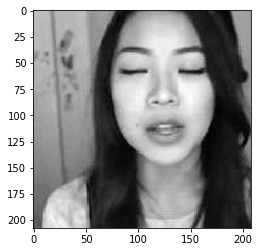

Y [0.48888889 0.50485437 0.55140187 0.51648352 0.44791667]


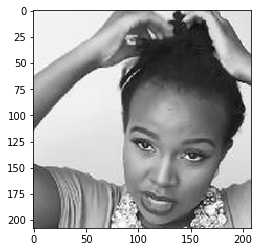

Y [0.8        0.54368932 0.64485981 0.45054945 0.69791667]


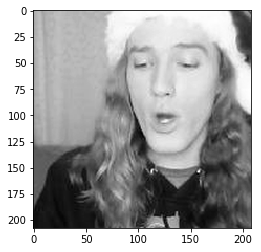

Y [0.33333333 0.59223301 0.35514019 0.2967033  0.4375    ]


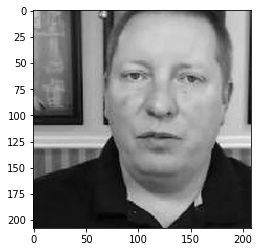

Y [0.45555556 0.40776699 0.38317757 0.47252747 0.41666667]


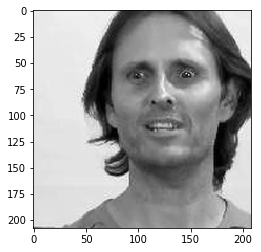

Y [0.45555556 0.4368932  0.41121495 0.46153846 0.53125   ]


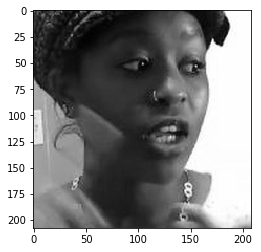

Y [0.62222222 0.63106796 0.62616822 0.59340659 0.60416667]


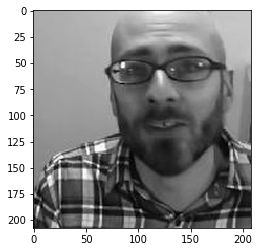

Y [0.47777778 0.38834951 0.36448598 0.42857143 0.32291667]


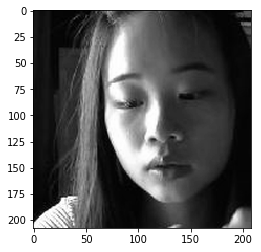

Y [0.42222222 0.68932039 0.22429907 0.62637363 0.4375    ]


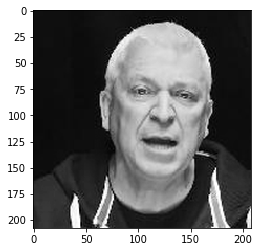

Y [0.64444444 0.45631068 0.51401869 0.56043956 0.5       ]


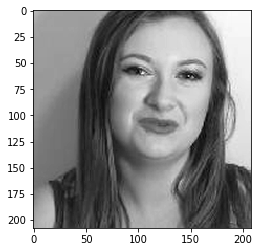

Y [0.6        0.38834951 0.60747664 0.51648352 0.54166667]


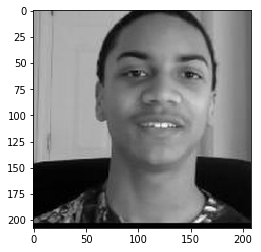

Y [0.33333333 0.33009709 0.40186916 0.46153846 0.3125    ]


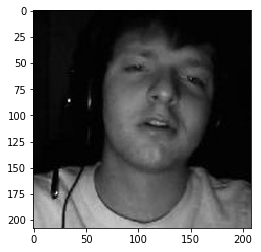

Y [0.51111111 0.58252427 0.34579439 0.57142857 0.22916667]


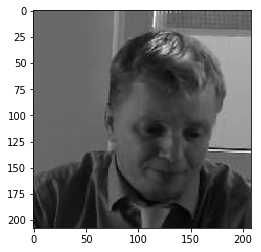

Y [0.36666667 0.22330097 0.29906542 0.32967033 0.27083333]


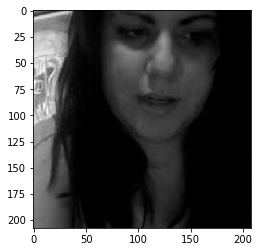

Y [0.61111111 0.58252427 0.40186916 0.68131868 0.5625    ]


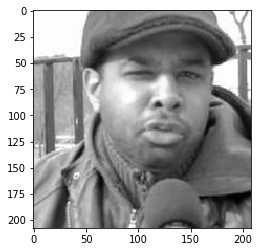

Y [0.46666667 0.37864078 0.4953271  0.41758242 0.41666667]


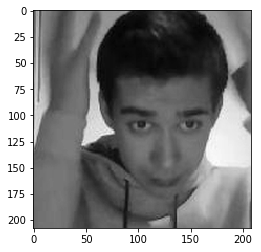

Y [0.42222222 0.40776699 0.42056075 0.54945055 0.28125   ]


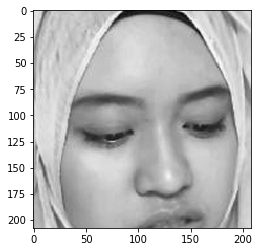

In [5]:
for i in range(0,10):
    print('Y',ds.data_test['Y'][i])
    plt.imshow(ds.data_test['X'][i].reshape(208,208), cmap='gray')
    plt.show();
    
for i in range(0,20):
    print('Y',ds.data_train['Y'][i])
    plt.imshow(ds.data_train['X'][i].reshape(208,208), cmap='gray')
    plt.show();

    

## Modelo y Entrenamiento

In [6]:
def save_model(index=0):
    name = 'cnn2b_train';
    model_json = classifier.to_json()
    with open("{}_{}.json".format(name, index), "w") as json_file:
        json_file.write(model_json)
    classifier.save_weights("{}_{}.h5".format(name,index),)
    print("Modelo guardado en disco","{}_{}.h5".format(name,index))

In [33]:
input_cla = Input(shape=(208,208,1,))

fm_size = 16;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(input_cla)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)



em_size = math.ceil(208/(2**8));


x = Dropout(0.8)(x)

# x = BatchNormalization()(x)

x = Reshape((em_size*em_size*fm_size,),input_shape=(em_size,em_size,fm_size))(x)
x=Dense(500,activation='relu', input_shape=(em_size*em_size*fm_size,))(x)
x=Dense(500,activation='relu')(x)
x=Dense(100,activation='relu')(x)
# x=Dense(500,activation='relu')(x)
# x=Dense(500,activation='relu')(x)
# x=Dense(500,activation='relu')(x)
# x=Dense(100,activation='relu')(x)
# x=Dense(100,activation='relu')(x)
output=Dense(5)(x)


adam = optimizers.adam(lr=1e-3)
classifier = Model(input_cla, output)
classifier.compile(optimizer=adam, loss=losses.mse)
# classifier.compile(optimizer=adam, loss=my_loss)

classifier.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 208, 208, 1)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 208, 208, 16)      160       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 104, 104, 16)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 104, 104, 32)      4640      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 52, 52, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 26, 26, 64)        0         
__________

In [12]:
save = 1;

In [13]:
global_history = {'val_loss':[], 'loss':[], 'mean_acc':[]}
best_acc = 0;

In [37]:
for i in range(0,10):
    h =classifier.fit(ds.data_train['X'], ds.data_train['Y'],
            epochs=1,
            batch_size=100,
            shuffle=False,
            validation_data=(ds.data_test['X'], ds.data_test['Y']))

    global_history['val_loss'].extend(h.history['val_loss'])
    global_history['loss'].extend(h.history['loss'])
    
    mean_acc = get_global_evaluation();
    global_history['mean_acc'].append(mean_acc);
    
    print('Mean-acc:',mean_acc)
    
    if mean_acc > best_acc:
        best_acc = mean_acc;
        save_model(index=save);


Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 30s 1ms/step - loss: 0.0130 - val_loss: 0.0220
Mean-acc: 87.99009464780087
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 30s 1ms/step - loss: 0.0120 - val_loss: 0.0240
Mean-acc: 87.47974541400222
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 30s 1ms/step - loss: 0.0114 - val_loss: 0.0221
Mean-acc: 87.9862528603565
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 30s 1ms/step - loss: 0.0105 - val_loss: 0.0223
Mean-acc: 87.96278045589516
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 30s 1ms/step - loss: 0.0099 - val_loss: 0.0219
Mean-acc: 88.1521444984729
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [=========================

In [39]:
classifier.load_weights("cnn2b_train_1.h5")
print("Modelo cargado desde disco ")

Modelo cargado desde disco 


In [38]:
print(max(global_history['mean_acc']))

88.8335796206304


In [40]:
print(global_history['mean_acc'])

[87.11600797866222, 87.9457569189458, 88.59024147641017, 88.3706610355055, 88.81476399959358, 88.75259696922305, 88.42258579945155, 88.31637727101536, 88.20938789595026, 87.99353101350168, 88.82083367989631, 88.74350969569221, 88.604662406647, 88.4245846026638, 88.83122340119861, 88.8193453003267, 88.8100479189223, 88.80216505569103, 88.81631006974297, 88.816565355765, 88.81368026899987, 88.81219626651286, 88.8335796206304, 88.74835518283409, 88.5713406680378, 88.24886295613251, 87.99009464780087, 87.47974541400222, 87.9862528603565, 87.96278045589516, 88.1521444984729, 87.76841301772107, 87.81606832380952, 87.90085183101709, 87.94996714555718, 87.99026140820902]


In [41]:
print(global_history['loss'])

[0.056015324644145215, 0.02125760139704267, 0.0200392594957964, 0.019232184500053724, 0.018220338340278086, 0.017376716317766158, 0.016357243495629944, 0.015268770106344288, 0.014155927838683002, 0.013143403445161152, 0.01667584479966686, 0.01591271507329064, 0.015166118521106772, 0.01424331502310358, 0.015920276469232116, 0.015733080925237314, 0.015675886078417706, 0.01555765537718699, 0.015748085439285624, 0.01575587704670797, 0.01573662908798606, 0.015704104571642143, 0.017795816180858636, 0.016368122446782405, 0.01519521380253041, 0.014142714963120157, 0.012980064929656962, 0.012039962468542314, 0.011374153084068448, 0.010499117175568637, 0.009899215772483339, 0.009511029249722518, 0.008834919489048894, 0.008360839137369748, 0.008026810544819534, 0.007887266114466348]


In [42]:
print(global_history['val_loss'])

[0.025115023479213655, 0.02206178744194043, 0.0198920900935787, 0.020685662068707714, 0.01924955747296088, 0.01940727289237331, 0.020463824835032, 0.020840186562805438, 0.021187959538061244, 0.022068284364284006, 0.01933621827270695, 0.01951312193960926, 0.019936221540295472, 0.020570329203398546, 0.019170054103717332, 0.01919991127608536, 0.019227424536089097, 0.019251641883316375, 0.019206033047774563, 0.01920562273375302, 0.01921360804276033, 0.01921868124897108, 0.01924446137622668, 0.01947050677439077, 0.020151061690243464, 0.021168730746749874, 0.022013936120852094, 0.024009729687698746, 0.02212601210928696, 0.02231740125227737, 0.02186147683841202, 0.023001742653985097, 0.022820741792205765, 0.022552557408065405, 0.02250043347081691, 0.02228323429383865]


In [45]:
%matplotlib inline

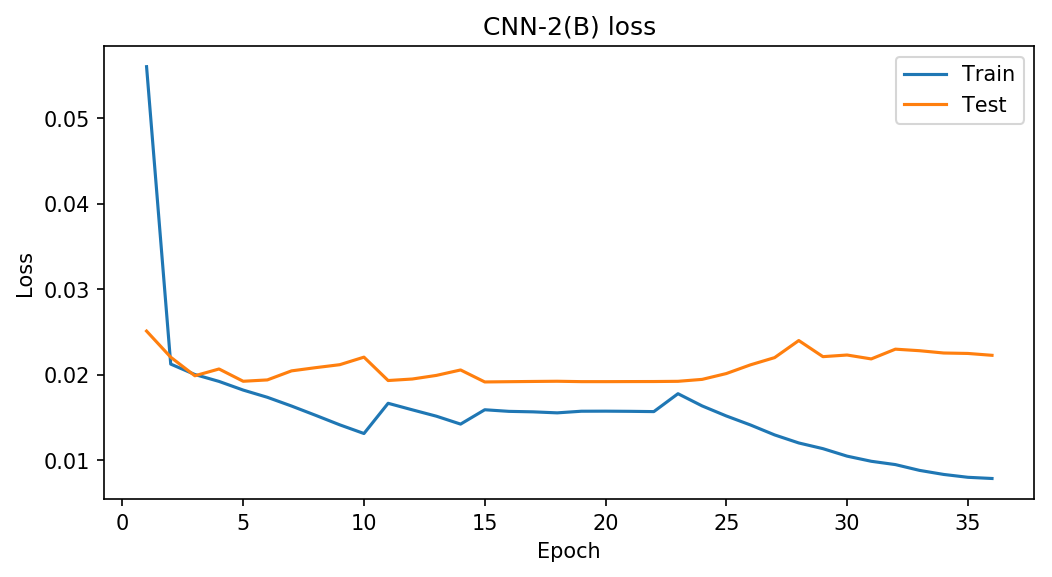

In [47]:
# Plot training & validation loss values
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)
x = np.arange(1,37,1);

axes.plot(x, global_history['loss'][0:200])
axes.plot(x, global_history['val_loss'][0:200])

plt.title('CNN-2(B) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')


fig.savefig("cnn2b-full.png",dpi=150) 

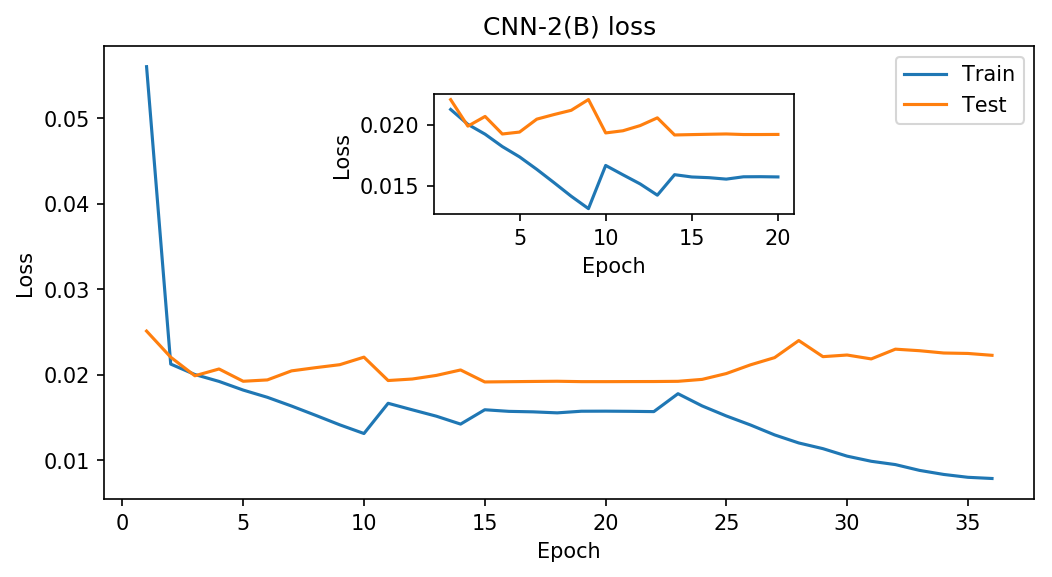

In [54]:
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)

x = np.arange(1,37,1);
axes.plot(x, global_history['loss'][0:200])
axes.plot(x, global_history['val_loss'][0:200])
plt.title('CNN-2(B) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

zoom_init = 1;
x = np.arange(zoom_init,21,1);
axes2=fig.add_axes([0.4,0.6,0.3,0.2])
axes2.plot(x, global_history['loss'][zoom_init:21])
axes2.plot(x, global_history['val_loss'][zoom_init:21])
axes2.set_xlabel("Epoch")
axes2.set_ylabel("Loss")

fig.savefig("cnn2b-mix.png",dpi=150) 

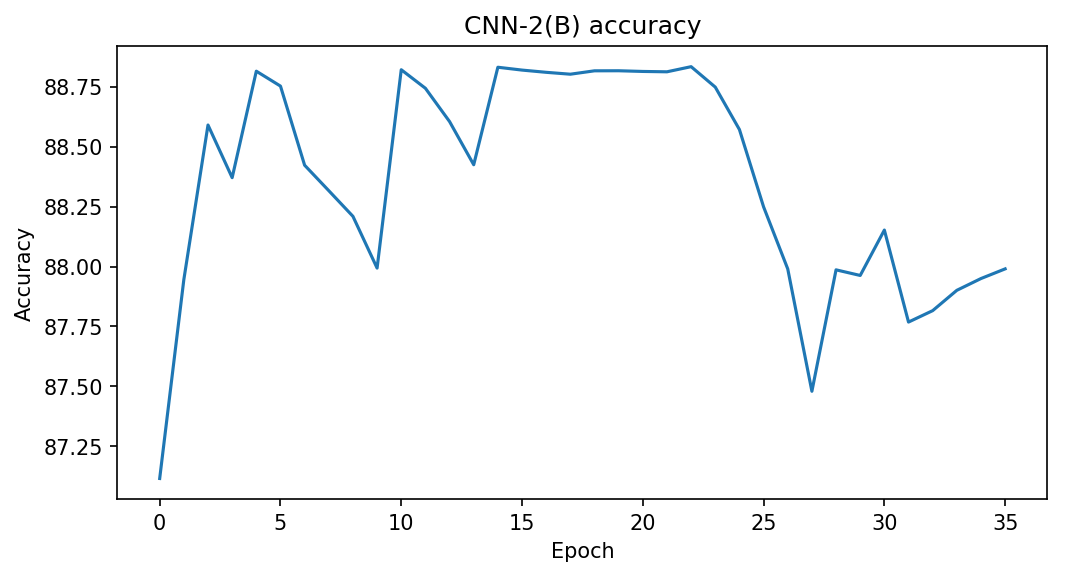

In [56]:
# Plot ACC
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)

x = np.arange(1,39,1);
axes.plot(global_history['mean_acc'][0:200])
plt.title('CNN-2(B) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


fig.savefig("cnn2b-acc.png",dpi=150) 

In [43]:
def test_regresor_per_factor(index=0, show=False):
    # Test como regresor
    tolerance_i = 0.1;
    X = ds.data_test['X'];
    Y = ds.data_test['Y'];
    out = classifier.predict(X)

    acc = 0;
    diff = 0;
    for i in range(out.shape[0]):         
        diff = diff + (1 - abs(Y[i][index]-out[i][index]));

    acc = diff / (out.shape[0] * 1);
    acc = acc *100;
    
    if show:
        print('Acc CL',acc);
    acc1 = acc;


    acc = 0;
    diff = 0;
    for i in range(out.shape[0]):  
        diff = abs(Y[i][index]-out[i][index]); 

        if diff<=tolerance_i:
            acc = acc + 1;

    acc = acc / (out.shape[0] * 1);
    acc = acc *100;

    if show:
        print('Acc uno tol',acc);   
    
    return (acc1,acc);

def get_global_evaluation(show=False):

    prom_cl = 0;
    prom_to = 0;
    
    if show:
        print('O');
    (a1,a2) = test_regresor_per_factor(index=0, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nC');
    (a1,a2) = test_regresor_per_factor(index=1, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nE');
    (a1,a2) = test_regresor_per_factor(index=2, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nA');
    (a1,a2) = test_regresor_per_factor(index=3, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nN');
    (a1,a2) = test_regresor_per_factor(index=4, show=show);
    prom_cl += a1;
    prom_to += a2;

    prom_cl = prom_cl/5;
    prom_to = prom_to/5;

    if show:
        print('\nPromedio');
        print('ChaLearn',prom_cl)
        print('Uno tol', prom_to)
        
    return prom_cl;

get_global_evaluation(show=True)

O
Acc CL 89.36381701029123
Acc uno tol 55.69529284944304

C
Acc CL 87.8612977105312
Acc uno tol 46.89184333453108

E
Acc CL 88.51566869794435
Acc uno tol 50.77254761049227

A
Acc CL 89.79332988092203
Acc uno tol 53.89867049946101

N
Acc CL 88.63378480346317
Acc uno tol 53.07222421846928

Promedio
ChaLearn 88.8335796206304
Uno tol 52.06611570247934


88.8335796206304

In [11]:
# Matriz de confusion Regresor
Y = ds.data_test['Y'][:];
tar = np.zeros(Y.shape)
out = classifier.predict(ds.data_test['X'][:])

# Preparo datos para la matriz
#  0: 0.00-0.05
#  1: 0.06-0.15
#  2: 0.16-0.25
#  3: 0.26-0.35
#  4: 0.36-0.45
#  5: 0.46-0.55
#  6: 0.56-0.65
#  7: 0.66-0.75
#  8: 0.76-0.85
#  9: 0.86-0.95
# 10: 0.96-1.00

for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        
        if Y[i][j]>=0.00 and Y[i][j]<=0.05:
            tar[i][j] = 0.0;
        elif Y[i][j]>0.05 and Y[i][j]<=0.15:
            tar[i][j] = 0.1;
        elif Y[i][j]>0.15 and Y[i][j]<=0.25:
            tar[i][j] = 0.2;
        elif Y[i][j]>0.25 and Y[i][j]<=0.35:
            tar[i][j] = 0.3;
        elif Y[i][j]>0.35 and Y[i][j]<=0.45:
            tar[i][j] = 0.4;
        elif Y[i][j]>0.45 and Y[i][j]<=0.55:
            tar[i][j] = 0.5;
        elif Y[i][j]>0.55 and Y[i][j]<=0.65:
            tar[i][j] = 0.6;
        elif Y[i][j]>0.65 and Y[i][j]<=0.75:
            tar[i][j] = 0.7;
        elif Y[i][j]>0.75 and Y[i][j]<=0.85:
            tar[i][j] = 0.8;
        elif Y[i][j]>0.85 and Y[i][j]<=0.95:
            tar[i][j] = 0.9;
        elif Y[i][j]>0.95 and Y[i][j]<=1.00:
            tar[i][j] = 1.0;
        

for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        
        if out[i][j]>=0.00 and out[i][j]<=0.05:
            out[i][j] = 0.0;
        elif out[i][j]>0.05 and out[i][j]<=0.15:
            out[i][j] = 0.1;
        elif out[i][j]>0.15 and out[i][j]<=0.25:
            out[i][j] = 0.2;
        elif out[i][j]>0.25 and out[i][j]<=0.35:
            out[i][j] = 0.3;
        elif out[i][j]>0.35 and out[i][j]<=0.45:
            out[i][j] = 0.4;
        elif out[i][j]>0.45 and out[i][j]<=0.55:
            out[i][j] = 0.5;
        elif out[i][j]>0.55 and out[i][j]<=0.65:
            out[i][j] = 0.6;
        elif out[i][j]>0.65 and out[i][j]<=0.75:
            out[i][j] = 0.7;
        elif out[i][j]>0.75 and out[i][j]<=0.85:
            out[i][j] = 0.8;
        elif out[i][j]>0.85 and out[i][j]<=0.95:
            out[i][j] = 0.9;
        elif out[i][j]>0.95 and out[i][j]<=1.00:
            out[i][j] = 1.0;

# Construccion de la matriz
matrix = np.zeros((11,11))

for i in range(out.shape[0]):
#     print(tar[i])
#     print(out[i],'\n')
    
    for j in range(out.shape[1]):
        
        mi = int(round(out[i][j] * 10));
        mj = int(round(tar[i][j] * 10));        
        
        if mi==11:
            mi = 10;
        
        matrix[mi][mj] += 1;
        
# Imprimimos con formato
just = 6;
header = '----'
header += repr(0.0).rjust(just)
header += repr(0.1).rjust(just)
header += repr(0.2).rjust(just)
header += repr(0.3).rjust(just)
header += repr(0.4).rjust(just)
header += repr(0.5).rjust(just)
header += repr(0.6).rjust(just)
header += repr(0.7).rjust(just)
header += repr(0.8).rjust(just)
header += repr(0.9).rjust(just)
header += repr(1.0).rjust(just)
print(header)

row_count = 0.0;

for i in range(matrix.shape[0]):
    row = str(i/10);
    
    for j in range(matrix.shape[1]):        
        row += repr(int(matrix[i][j])).rjust(just)
        
    row += repr(int(sum(matrix[i]))).rjust(just)
    
    print(row)
    row_count += 0.1;

row = '---';
for i in range(matrix.shape[1]):
    row += repr(int(sum(matrix[:,i]))).rjust(just)
print(row)

success = 0;
for i in range(0,11):
    success += matrix[i][i]
    
print('\n\nCorrectos',int(success))
print('Total',int(sum(sum(matrix))))
print('Acc',success/sum(sum(matrix)))

----   0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.0
0.0     0     0     0     0     0     0     0     0     0     0     0     0
0.1     0     0     0     0     0     0     0     0     0     0     0     0
0.2     0     0     2     2     0     2     0     0     0     0     0     6
0.3     0    11    34    23     2    23    17    19     1     0     0   130
0.4     4    40   140   363   587   438   247   129    18     3     0  1969
0.5     0    11   187   668  1372  1819  1587   953   269    37     1  6904
0.6     0     3    33   130   520   932  1273  1188   441   144     8  4672
0.7     0     0     1     1     5    36    37    57    60    35     2   234
0.8     0     0     0     0     0     0     0     0     0     0     0     0
0.9     0     0     0     0     0     0     0     0     0     0     0     0
1.0     0     0     0     0     0     0     0     0     0     0     0     0
---     4    65   397  1187  2486  3250  3161  2346   789   219    11


Correctos 3761
Total 

In [44]:
# Test como clasificacion binaria
def test_factor_class(index=0):
    X = ds.data_test['X'];
    Y = ds.data_test['Y'];
    out = classifier.predict(X)
    
    limit = 0.5714; # 4/7
#     limit = 0.5;
    
    acc = 0;

    for i in range(out.shape[0]): 
        if Y[i][index]>limit and out[i][index]>limit:
            acc = acc + 1;
        elif Y[i][index]<=limit and out[i][index]<=limit:
            acc = acc + 1;

    acc = acc / out.shape[0];
    acc *= 100;
    
    return acc;

def get_global_acc(show=False):

    acc_global = 0;

    acc = test_factor_class(index=0);
    acc_global += acc;
    if show:
        print('O',acc);   

    acc = test_factor_class(index=1);
    acc_global += acc;
    if show:
        print('C',acc);    

    acc = test_factor_class(index=2);
    acc_global += acc;
    if show:
        print('E',acc);  

    acc = test_factor_class(index=3);
    acc_global += acc;
    if show:
        print('A',acc);    

    acc = test_factor_class(index=4);
    acc_global += acc;
    if show:
        print('N',acc);  

    acc_global = acc_global / 5;
    if show:
        print('\nPromedio',acc_global)
        
    return acc_global;

prom = get_global_acc(show=True);
# print(prom)

O 62.91771469637082
C 66.58282429033417
E 71.00251527128998
A 57.060725835429395
N 65.46891843334531

Promedio 64.60653970535394


In [14]:
# Matriz de confusion para clasificacion binaria
Y = ds.data_test['Y'][:];
out = classifier.predict(ds.data_test['X'])

limit = 0.5714; # 4/7

# Construccion de la matriz
matrix = np.zeros((2,2))
TP = 0;
TN = 0;
FP = 0;
FN = 0;

for i in range(out.shape[0]):
#     print(tar[i])
#     print(out[i],'\n')
    
    for j in range(out.shape[1]):
        
        if Y[i][j]<=limit and out[i][j]<=limit:      
            matrix[0][0] += 1; 
            TN += 1;
        elif Y[i][j]<=limit and out[i][j]>limit:         
            matrix[1][0] += 1; 
            FP += 1;
        elif Y[i][j]>limit and out[i][j]<=limit:        
            matrix[0][1] += 1; 
            FN += 1;
        elif Y[i][j]>limit and out[i][j]>limit:        
            matrix[1][1] += 1; 
            TP += 1;
            
        
# Imprimimos con formato
just = 8;
header = '----'
header += repr(0).rjust(just)
header += repr(1).rjust(just)
print(header)


for i in range(matrix.shape[0]):
    row = str(i)+'    ';
    
    for j in range(matrix.shape[1]):        
        row += repr(int(matrix[i][j])).rjust(just)
        
    row += repr(int(sum(matrix[i]))).rjust(just)
    
    print(row)

row = '-----';
for i in range(matrix.shape[1]):
    row += repr(int(sum(matrix[:,i]))).rjust(just)
print(row)

success = 0;
for i in range(0,2):
    success += matrix[i][i]
    
print('\nCorrectos',int(success))
print('Total',int(sum(sum(matrix))))
print('Acc',success/sum(sum(matrix)))

precision = TP/(TP+FP);
recall    = TP/(TP+FN);
acc       = (TP+TN)/(TP+TN+FP+FN);
f1        = (2*precision*recall)/(precision+recall)

print('\nPrecison',precision)
print('Recall',recall)
print('Acc',acc)
print('F1',f1)


----       0       1
0        6980    3693   10673
1        1071    2171    3242
-----    8051    5864

Correctos 9151
Total 13915
Acc 0.6576356449874237

Precison 0.6696483652066626
Recall 0.370225102319236
Acc 0.6576356449874237
F1 0.47682846474851753
